In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from transformers import MarianTokenizer, MarianMTModel
from datasets import Dataset
import evaluate
import matplotlib.pyplot as plt
import os
import logging
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Configuration for each language pair
CONFIG = {
    "es": {
        "dataset": "spa.txt",
        "output_dir": "fine_tuned_en_es",
        "model_name": "Helsinki-NLP/opus-mt-en-es",
        "target_language": "Spanish"
    },
    "deu": {
        "dataset": "deu.txt",
        "output_dir": "fine_tuned_en_deu",
        "model_name": "Helsinki-NLP/opus-mt-en-de",
        "target_language": "German"
    },
    "ita": {
        "dataset": "ita.txt",
        "output_dir": "fine_tuned_en_ita",
        "model_name": "Helsinki-NLP/opus-mt-en-it",
        "target_language": "Italian"
    }
}

In [3]:
def setup_logging(output_dir):
    """Set up logging for the given output directory."""
    log_dir = os.path.join(output_dir, "logs")
    os.makedirs(log_dir, exist_ok=True)
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(os.path.join(log_dir, 'training_evaluation.log')),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)

In [4]:
def preprocess_data(examples, tokenizer):
    inputs = examples["english"]
    targets = examples["target"]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length", return_tensors="pt")
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length", return_tensors="pt")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [5]:
def train_model(model, tokenizer, train_df, val_df, output_dir, batch_size=8, num_epochs=5, lr=2e-5):
    logger = setup_logging(output_dir)
    logger.info("Starting model training...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    
    logger.info("Tokenizing datasets...")
    tokenized_train = train_dataset.map(
        lambda x: preprocess_data(x, tokenizer), 
        batched=True,
        remove_columns=train_dataset.column_names
    )
    tokenized_val = val_dataset.map(
        lambda x: preprocess_data(x, tokenizer), 
        batched=True,
        remove_columns=val_dataset.column_names
    )
    
    tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    tokenized_val.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    
    train_dataloader = DataLoader(tokenized_train, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(tokenized_val, batch_size=batch_size)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    
    logger.info(f"Training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, batch in enumerate(train_dataloader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            if batch_idx % 100 == 0:
                logger.info(f"Epoch {epoch+1}, Batch {batch_idx}, Loss: {loss.item()}")
        
        avg_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_loss)
        logger.info(f"Epoch {epoch+1} - Average Training Loss: {avg_loss}")
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_dataloader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss += outputs.loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        logger.info(f"Epoch {epoch+1} - Average Validation Loss: {avg_val_loss}")
    
    # Save model and tokenizer
    model_dir = os.path.join(output_dir, "model")
    os.makedirs(model_dir, exist_ok=True)
    model.save_pretrained(model_dir)
    tokenizer.save_pretrained(model_dir)
    logger.info(f"Model and tokenizer saved to {model_dir}")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    epochs_range = range(1, num_epochs + 1)
    if num_epochs > 1:
        plt.plot(epochs_range, train_losses, label='Training Loss')
        plt.plot(epochs_range, val_losses, label='Validation Loss')
    else:
        plt.scatter(epochs_range, train_losses, label='Training Loss', color='blue')
        plt.scatter(epochs_range, val_losses, label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plots_dir = os.path.join(output_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    plt.savefig(os.path.join(plots_dir, 'training_history.png'))
    plt.show()  # Display on screen
    logger.info("Training history plot saved and displayed.")
    
    return model, tokenizer

In [6]:
def compute_metrics(model_path, test_df, lang_code, device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    """Compute BLEU, METEOR, and BERTScore for a saved model."""
    logger = setup_logging(os.path.dirname(model_path))
    logger.info(f"Computing metrics for {lang_code}...")

    tokenizer = MarianTokenizer.from_pretrained(model_path)
    model = MarianMTModel.from_pretrained(model_path)
    model.to(device)
    model.eval()

    bleu = evaluate.load("bleu")
    meteor = evaluate.load("meteor")
    from bert_score import score as bert_score

    predictions = []
    references = []
    with torch.no_grad():
        for i in range(0, len(test_df), 8):
            batch = test_df[i:i+8]
            inputs = tokenizer(list(batch["english"]), return_tensors="pt", padding=True, truncation=True).to(device)
            outputs = model.generate(**inputs)
            preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            refs = list(batch["target"])
            predictions.extend(preds)
            references.extend([ref] for ref in refs)

    bleu_result = bleu.compute(predictions=predictions, references=references)["bleu"]
    meteor_result = meteor.compute(predictions=predictions, references=[ref[0] for ref in references])["meteor"]
    P, R, F1 = bert_score(predictions, [ref[0] for ref in references], lang=lang_code, verbose=False)
    bertscore_result = F1.mean().item()

    logger.info(f"BLEU Score: {bleu_result}")
    logger.info(f"METEOR Score: {meteor_result}")
    logger.info(f"BERTScore F1: {bertscore_result}")

    return {"bleu": bleu_result, "meteor": meteor_result, "bertscore": bertscore_result}

In [7]:
def train_and_evaluate(lang_code):
    """Train and evaluate a model for a specific language."""
    config = CONFIG[lang_code]
    dataset_path = config["dataset"]
    output_dir = config["output_dir"]
    model_name = config["model_name"]
    target_language = config["target_language"]  # Added target language name
    
    logger = setup_logging(output_dir)
    logger.info(f"Processing language: {lang_code} (English to {target_language})")
    
    # Load and preprocess data
    logger.info("Loading and preprocessing data...")
    df = pd.read_csv(dataset_path, sep='\t', header=None)
    df = df.iloc[:, [0, 1]]
    df.columns = ['english', 'target']
    df = df.dropna().drop_duplicates()
    df['english'] = df['english'].str.lower().str.strip().str.replace(r'[^\w\s.]', '', regex=True)
    df['target'] = df['target'].str.lower().str.strip().str.replace(r'[^\w\s.]', '', regex=True)
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)
    train_subset = train_df[:10000]
    
    logger.info(f"Data shape: {df.shape}")
    
    # Plot sentence length distribution with target language specified
    df['english_length'] = df['english'].str.split().str.len()
    df['target_length'] = df['target'].str.split().str.len()
    plt.figure(figsize=(10, 5))
    plt.hist(df['english_length'], bins=50, alpha=0.5, label='English')
    plt.hist(df['target_length'], bins=50, alpha=0.5, label=target_language)  # Use target language name
    plt.title(f'Sentence Length Distribution (English vs {target_language})')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.legend()
    plots_dir = os.path.join(output_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    plt.savefig(os.path.join(plots_dir, 'sentence_length_dist.png'))
    plt.show()  # Display on screen
    logger.info(f"Sentence length distribution plot for English vs {target_language} saved and displayed.")
    
    # Train model
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    model, tokenizer = train_model(model, tokenizer, train_subset, val_df, output_dir)
    
    # Evaluate model
    model_path = os.path.join(output_dir, "model")
    metrics = compute_metrics(model_path, test_df, lang_code)
    
    # Save metrics to a file
    with open(os.path.join(output_dir, "metrics.txt"), "w") as f:
        f.write(f"BLEU Score: {metrics['bleu']}\n")
        f.write(f"METEOR Score: {metrics['meteor']}\n")
        f.write(f"BERTScore F1: {metrics['bertscore']}\n")
    logger.info(f"Metrics saved to {os.path.join(output_dir, 'metrics.txt')}")
    
    return metrics

In [8]:
def main():
    all_metrics = {}
    
    # Train and evaluate for each language
    for lang_code in CONFIG.keys():
        metrics = train_and_evaluate(lang_code)
        all_metrics[lang_code] = metrics
    
    # Visualize metrics across languages
    general_plots_dir = "general_plots"
    os.makedirs(general_plots_dir, exist_ok=True)
    
    for metric_name in ["bleu", "meteor", "bertscore"]:
        plt.figure(figsize=(8, 4))
        plt.bar(all_metrics.keys(), [all_metrics[lang][metric_name] for lang in all_metrics])
        plt.title(f'{metric_name.upper()} Scores by Language')
        plt.ylabel(f'{metric_name.upper()} Score')
        plt.savefig(os.path.join(general_plots_dir, f'{metric_name}_scores.png'))
        plt.show()  # Display on screen
        logging.getLogger(__name__).info(f"{metric_name.upper()} scores plot saved and displayed.")

2025-04-05 11:27:00,792 - INFO - Processing language: es (English to Spanish)
2025-04-05 11:27:00,792 - INFO - Loading and preprocessing data...
2025-04-05 11:27:01,437 - INFO - Data shape: (118964, 2)


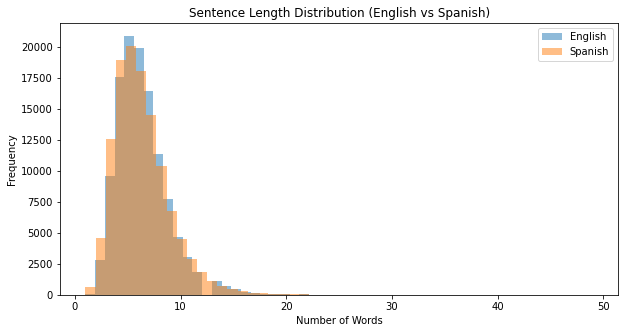

2025-04-05 11:27:02,433 - INFO - Sentence length distribution plot for English vs Spanish saved and displayed.
2025-04-05 11:27:04,680 - INFO - Starting model training...
2025-04-05 11:27:04,705 - INFO - Tokenizing datasets...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/11896 [00:00<?, ? examples/s]

2025-04-05 11:27:09,347 - INFO - Training for 5 epochs...
2025-04-05 11:27:10,701 - INFO - Epoch 1, Batch 0, Loss: 4.616606712341309
2025-04-05 11:29:20,039 - INFO - Epoch 1, Batch 100, Loss: 0.04619515687227249
2025-04-05 11:31:28,621 - INFO - Epoch 1, Batch 200, Loss: 0.048686329275369644
2025-04-05 11:33:37,114 - INFO - Epoch 1, Batch 300, Loss: 0.02456735074520111
2025-04-05 11:35:45,434 - INFO - Epoch 1, Batch 400, Loss: 0.04319922253489494
2025-04-05 11:37:53,897 - INFO - Epoch 1, Batch 500, Loss: 0.03295324370265007
2025-04-05 11:40:02,401 - INFO - Epoch 1, Batch 600, Loss: 0.06815744936466217
2025-04-05 11:42:10,813 - INFO - Epoch 1, Batch 700, Loss: 0.01470460370182991
2025-04-05 11:44:19,253 - INFO - Epoch 1, Batch 800, Loss: 0.04024409502744675
2025-04-05 11:46:27,636 - INFO - Epoch 1, Batch 900, Loss: 0.03542567789554596
2025-04-05 11:48:35,933 - INFO - Epoch 1, Batch 1000, Loss: 0.036357782781124115
2025-04-05 11:50:44,191 - INFO - Epoch 1, Batch 1100, Loss: 0.041073475033

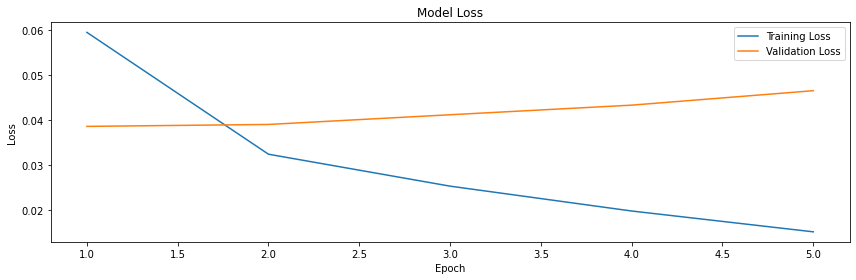

2025-04-05 14:30:35,786 - INFO - Training history plot saved and displayed.
2025-04-05 14:30:35,792 - INFO - Computing metrics for es...
[nltk_data] Downloading package wordnet to
[nltk_data]     /storage/home/haa5622/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /storage/home/haa5622/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /storage/home/haa5622/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertMo

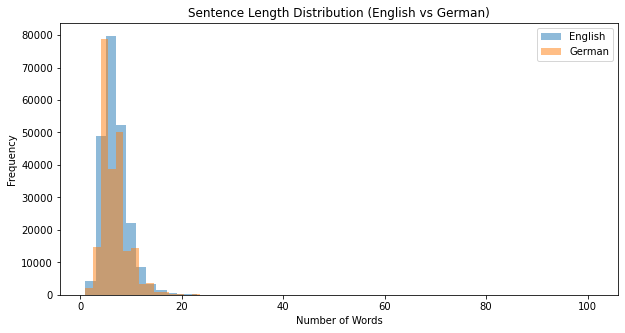

2025-04-05 14:44:44,825 - INFO - Sentence length distribution plot for English vs German saved and displayed.
2025-04-05 14:44:47,236 - INFO - Starting model training...
2025-04-05 14:44:47,267 - INFO - Tokenizing datasets...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/22153 [00:00<?, ? examples/s]

2025-04-05 14:44:52,991 - INFO - Training for 5 epochs...
2025-04-05 14:44:54,193 - INFO - Epoch 1, Batch 0, Loss: 7.824183940887451
2025-04-05 14:46:56,025 - INFO - Epoch 1, Batch 100, Loss: 0.1212577223777771
2025-04-05 14:48:58,164 - INFO - Epoch 1, Batch 200, Loss: 0.06977377831935883
2025-04-05 14:51:00,440 - INFO - Epoch 1, Batch 300, Loss: 0.10647083818912506
2025-04-05 14:53:02,722 - INFO - Epoch 1, Batch 400, Loss: 0.09402884542942047
2025-04-05 14:55:05,017 - INFO - Epoch 1, Batch 500, Loss: 0.06001149117946625
2025-04-05 14:57:07,337 - INFO - Epoch 1, Batch 600, Loss: 0.074359230697155
2025-04-05 14:59:09,729 - INFO - Epoch 1, Batch 700, Loss: 0.04246135056018829
2025-04-05 15:01:11,883 - INFO - Epoch 1, Batch 800, Loss: 0.030468903481960297
2025-04-05 15:03:14,071 - INFO - Epoch 1, Batch 900, Loss: 0.050476059317588806
2025-04-05 15:05:16,194 - INFO - Epoch 1, Batch 1000, Loss: 0.09248743206262589
2025-04-05 15:07:18,306 - INFO - Epoch 1, Batch 1100, Loss: 0.052049387246370

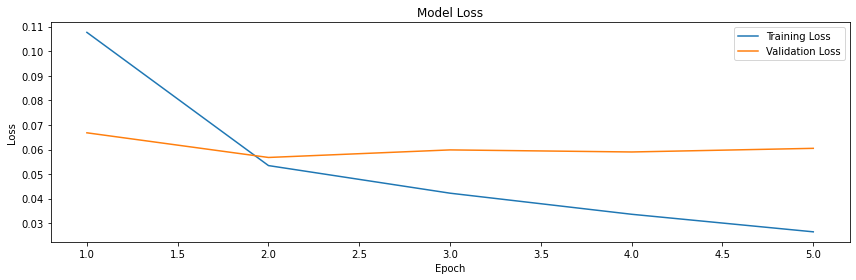

2025-04-05 18:20:24,181 - INFO - Training history plot saved and displayed.
2025-04-05 18:20:24,254 - INFO - Computing metrics for deu...
[nltk_data] Downloading package wordnet to
[nltk_data]     /storage/home/haa5622/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /storage/home/haa5622/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /storage/home/haa5622/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertM

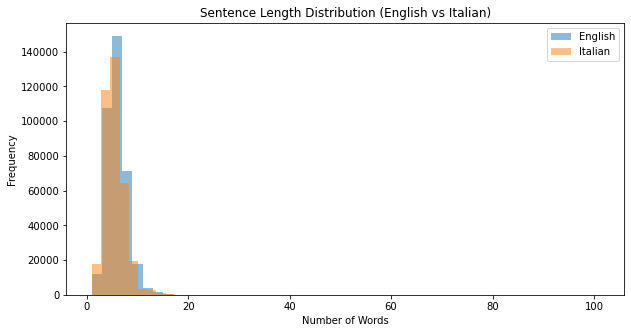

2025-04-05 18:47:46,511 - INFO - Sentence length distribution plot for English vs Italian saved and displayed.
2025-04-05 18:47:49,934 - INFO - Starting model training...
2025-04-05 18:47:49,971 - INFO - Tokenizing datasets...


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/36420 [00:00<?, ? examples/s]

2025-04-05 18:47:57,700 - INFO - Training for 5 epochs...
2025-04-05 18:47:59,082 - INFO - Epoch 1, Batch 0, Loss: 10.483660697937012
2025-04-05 18:50:19,926 - INFO - Epoch 1, Batch 100, Loss: 0.13521677255630493
2025-04-05 18:52:41,229 - INFO - Epoch 1, Batch 200, Loss: 0.039624374359846115
2025-04-05 18:55:02,322 - INFO - Epoch 1, Batch 300, Loss: 0.03105526603758335
2025-04-05 18:57:23,485 - INFO - Epoch 1, Batch 400, Loss: 0.026505235582590103
2025-04-05 18:59:44,516 - INFO - Epoch 1, Batch 500, Loss: 0.022781208157539368
2025-04-05 19:02:05,532 - INFO - Epoch 1, Batch 600, Loss: 0.04089543968439102
2025-04-05 19:04:26,509 - INFO - Epoch 1, Batch 700, Loss: 0.0489480160176754
2025-04-05 19:06:47,514 - INFO - Epoch 1, Batch 800, Loss: 0.022402217611670494
2025-04-05 19:09:08,590 - INFO - Epoch 1, Batch 900, Loss: 0.03125757724046707
2025-04-05 19:11:29,677 - INFO - Epoch 1, Batch 1000, Loss: 0.03532053157687187
2025-04-05 19:13:50,668 - INFO - Epoch 1, Batch 1100, Loss: 0.0315859131

In [ ]:
if __name__ == "__main__":
    main()